In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision

In [32]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
tlen = len(train_dataset)
train_dataset, val_dataset = random_split(train_dataset, [int(tlen-tlen*0.2), int(tlen*0.2)])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
def training_process_plot(train_loss_arr, val_loss_arr):
    plt.figure(figsize=(10, 8))
    plt.plot(train_loss_arr, label='Train')
    plt.plot(val_loss_arr, label='Validation')
    plt.legend()

In [5]:
def epochs_output_visualizer(epochs_output):
    for epoch, (img, output) in enumerate(epochs_output):
        img, output = img.reshape(-1, 28, 28).unsqueeze(1), output.reshape(-1, 28, 28).unsqueeze(1)

        plt.figure(figsize=(10, 5))
        plt.title(f'Epoch {epoch}')
        plt.axis('off')
        plt.imshow(torchvision.utils.make_grid(torch.cat((img, output)), nrow=8).cpu().permute(1, 2, 0));
        plt.show()

# VAE

KL Divergencein VAE: $\sum^n_{i=1}{\sigma_i^2 + \mu_i^2 - log(\sigma_i) - 1}$

In [14]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dim, device):
        super(VariationalEncoder, self).__init__()

        self.device = device

        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear_mu = nn.Linear(128, latent_dim)
        self.linear_sigma = nn.Linear(128, latent_dim)

        self.eps = torch.distributions.Normal(0, 1)

        self.KL = 0
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))

        mu = self.linear_mu(x)
        sigma = torch.exp(self.linear_sigma(x)) # Reason of using torch.exp -> Forcing sigma to be + 

        z = mu + sigma*self.eps.sample(mu.shape).to(self.device)

        self.KL = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z

In [15]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        self.dec1 = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3*3*32),
            nn.ReLU(),
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.dec1(x)
        x = x.reshape(-1, 32, 3, 3)
        out = self.dec2(x)

        return out

In [16]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim, device):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = VariationalEncoder(latent_dim, device)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Train

In [143]:
z_dim = 8
num_epochs = 25

In [144]:
model = VariationalAutoencoder(z_dim, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [145]:
epochs_output = []

train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    train_loss, val_loss = .0, .0

    model.train()
    for img, _ in train_dataloader:
        img = img.to(device)

        output = model(img)
        loss = ((output - img)**2).sum() + model.encoder.KL

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss_arr.append(train_loss/len(train_dataloader.dataset))
        
    model.eval()
    with torch.no_grad():
        for idx, (img, _) in enumerate(val_dataloader):
            img = img.to(device)
            output = model(img)
            loss = ((output - img)**2).sum() + model.encoder.KL
            val_loss += loss.item()

            if idx == 0:
                epochs_output.append((img, output))    
    val_loss_arr.append(val_loss/len(val_dataloader.dataset))

    print(f'Epoch: {"{:2d}".format(epoch)} -> \t Train Loss: {"%.10f"%train_loss_arr[-1]} \t Validation Loss: {"%.10f"%val_loss_arr[-1]}')

Epoch:  0 -> 	 Train Loss: 65.6826733297 	 Validation Loss: 41.1676187528
Epoch:  1 -> 	 Train Loss: 37.5914177195 	 Validation Loss: 35.6011908264
Epoch:  2 -> 	 Train Loss: 34.9252630564 	 Validation Loss: 34.6434817734
Epoch:  3 -> 	 Train Loss: 34.0115076396 	 Validation Loss: 33.7826250216
Epoch:  4 -> 	 Train Loss: 33.4595692164 	 Validation Loss: 33.2868968328
Epoch:  5 -> 	 Train Loss: 33.0598681513 	 Validation Loss: 32.8762824516
Epoch:  6 -> 	 Train Loss: 32.7322554296 	 Validation Loss: 32.7235919367
Epoch:  7 -> 	 Train Loss: 32.4736542587 	 Validation Loss: 32.4886863861
Epoch:  8 -> 	 Train Loss: 32.3187653707 	 Validation Loss: 32.3795179253
Epoch:  9 -> 	 Train Loss: 32.1325940145 	 Validation Loss: 32.1028375219
Epoch: 10 -> 	 Train Loss: 32.0194135539 	 Validation Loss: 32.0393272998
Epoch: 11 -> 	 Train Loss: 31.9033911031 	 Validation Loss: 31.9098145014
Epoch: 12 -> 	 Train Loss: 31.7964969813 	 Validation Loss: 32.0910682182
Epoch: 13 -> 	 Train Loss: 31.74011474

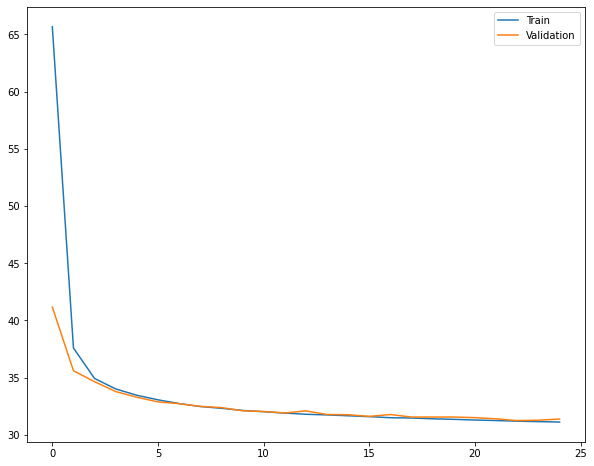

In [149]:
training_process_plot(train_loss_arr, val_loss_arr)

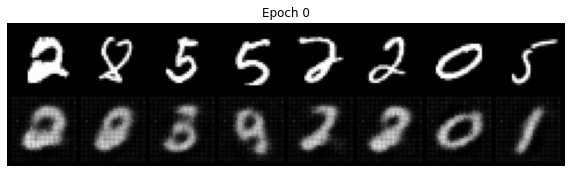

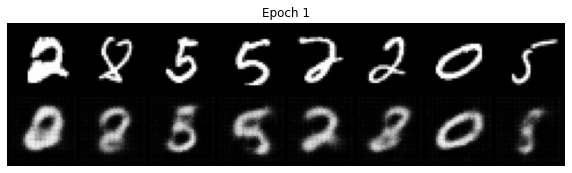

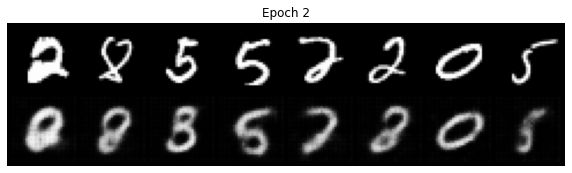

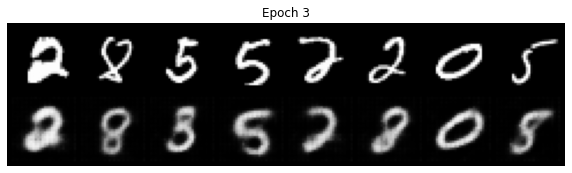

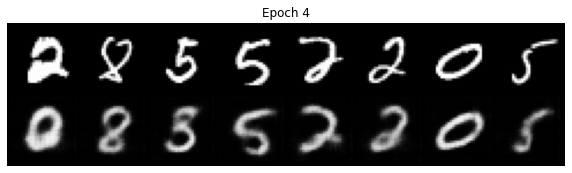

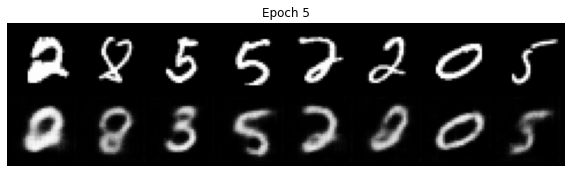

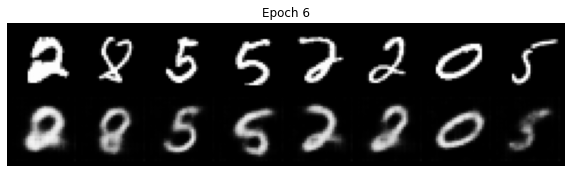

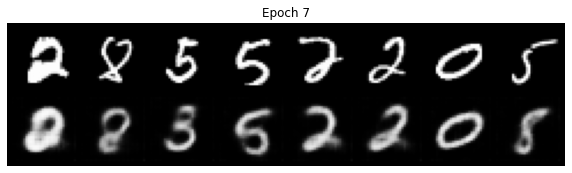

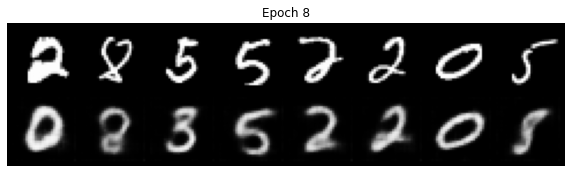

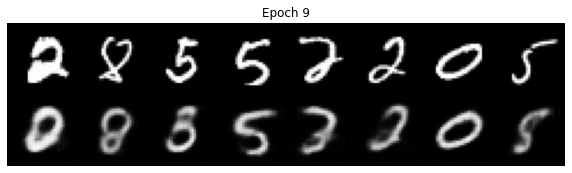

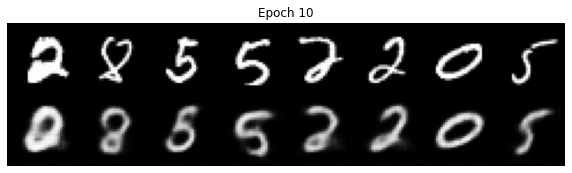

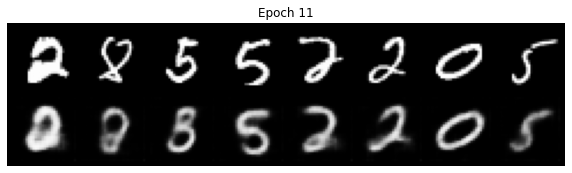

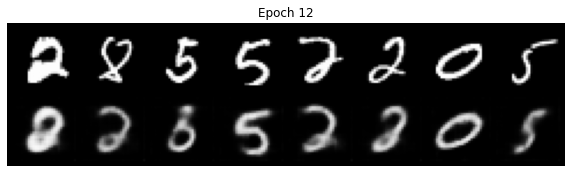

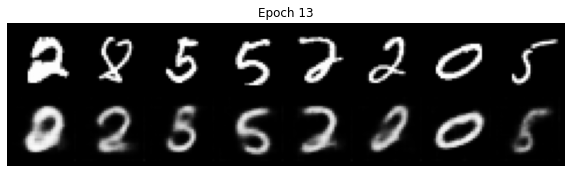

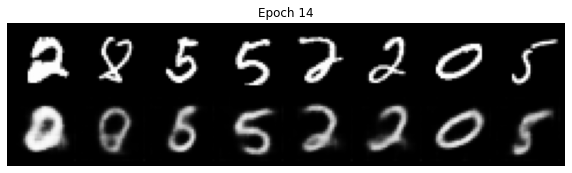

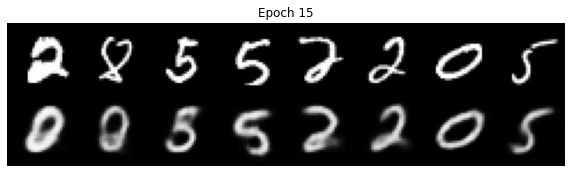

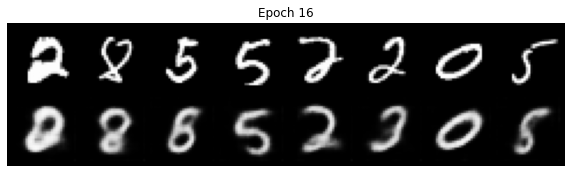

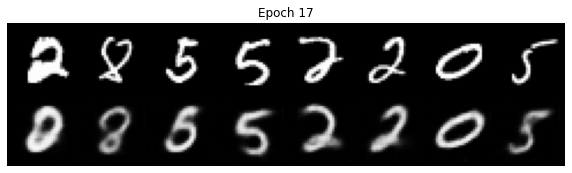

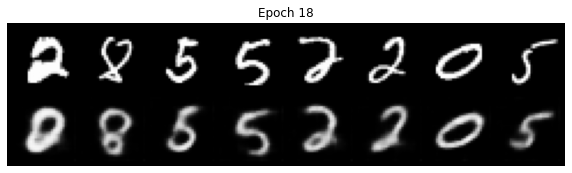

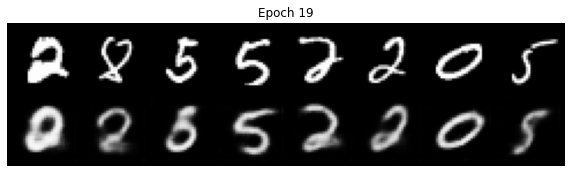

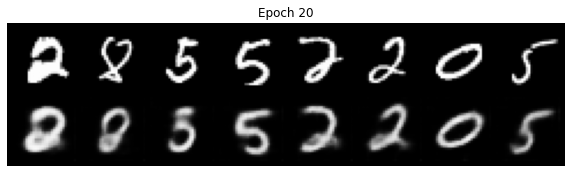

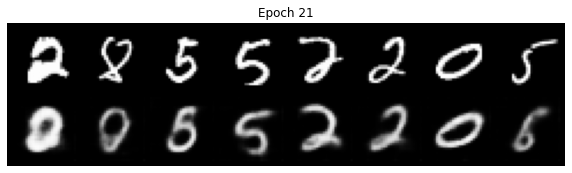

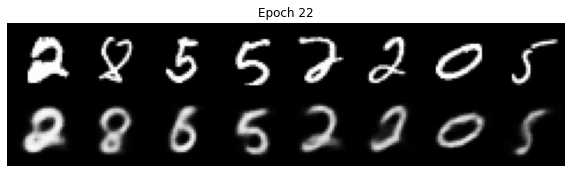

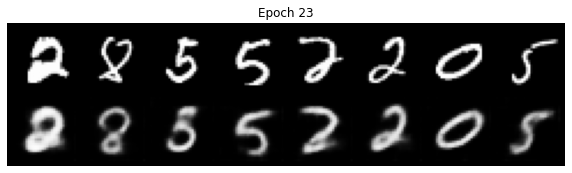

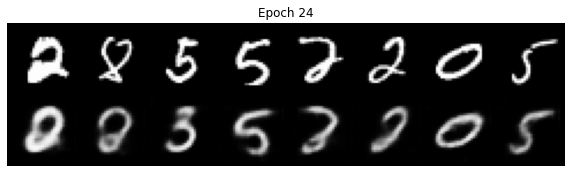

In [150]:
epochs_output_visualizer(epochs_output)

# Generating Samples

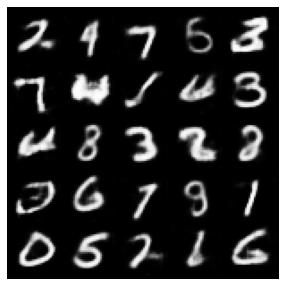

In [151]:
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(
    torch.cat([model.decoder(torch.normal(0, 1, size=(1, 8)).to(device)) for _ in range(25)]),
    nrow=5
).cpu().permute(1, 2, 0));

## Resources

- [Variational Autoencoder with Pytorch](https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b)